In [13]:
import numpy as np
import nibabel as nib
from nilearn import datasets
import os.path as op
import os
from nilearn import signal
import pandas as pd

sub = '01'
bids_folder = '/mnt_03/ds-smile1'
n_components = 10

In [15]:
ses=2
task= 'rest' # 'magjudge' #

runs = range(1,4) if task=='magjudge' else range(1,2)
target_dir = op.join(bids_folder, 'derivatives', 'gradients', f'sub-{sub}', f'ses-{ses}')


In [16]:
#CM unfiltered generated before?
from utils import cleanTS, get_basic_mask

mask, labeling_noParcel = get_basic_mask()
clean_ts = cleanTS(sub, ses=ses,runs=runs, bids_folder=bids_folder,task=task) # checks if fsav5-file exists, if not, creates it
seed_ts = clean_ts[mask]

from nilearn.connectome import ConnectivityMeasure
from scipy.sparse.csgraph import connected_components

cm_file = op.join(bids_folder, 'derivatives', 'correlation_matrices', f'sub-{sub}_ses-{ses}_task-{task}_unfiltered.npy')
if (os.path.exists(cm_file) == False):
    correlation_measure = ConnectivityMeasure(kind='correlation')
    cm = correlation_measure.fit_transform([seed_ts.T])[0] #correlation_matrix_noParcel
    print(f'sub-{sub} ses-{ses}_task-{task} : raw connectivity matrix estimated')    
    np.save(cm_file, cm)
cm = np.load(cm_file)

# filter out nodes that are not connected to the rest
cc_mask_file = op.join(target_dir,f'sub-{sub}_ses-{ses}_task-{task}_cc-mask_space-fsaverag5.npy')
if (os.path.exists(cc_mask_file) == False):
    cc = connected_components(cm)
    mask_cc = cc[1] == 0 # all nodes in 0 belong to the largest connected component, check #-components in cc[0]
    np.save(cc_mask_file, mask_cc) # save all together
    print(f'connected components derived & mask saved, N={cc[0]} CCs')    
mask_cc = np.load(cc_mask_file)
mask, labeling_noParcel = get_basic_mask()
mask[mask == True] = mask_cc # mark nodes not in component 0  as False in mask
cm_filtered = cm[mask_cc, :][:, mask_cc]
print('connectivty matrix loaded and filtered with cc_mask')    


sub-01 ses-2_task-rest : raw connectivity matrix estimated
connected components derived & mask saved, N=1 CCs
connectivty matrix loaded and filtered with cc_mask


##
for ses-1 task-magduge 1 CCs
for ses-1 task-rest 36 CCs ?!!

In [17]:
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels

gm = GradientMaps(n_components=n_components) # defaults: approacch = 'dm', kernel = None
gm.fit(cm_filtered)

np.save(op.join(target_dir,f'sub-{sub}_ses-{ses}_task-{task}_lambdas_space-fsaverag5_n10.npy'), gm.lambdas_) # save all together
gm_= gm.gradients_.T 
grad = [None] * n_components
for i, g in enumerate(gm_): # gm.gradients_.T
    grad[i] = map_to_labels(g, labeling_noParcel, mask=mask, fill=np.nan)
np.save(op.join(target_dir,f'sub-{sub}_ses-{ses}_task-{task}_gradients_space-fsaverag5_n10.npy'), grad) # save all together
print(f'finished GMs sub-{sub}_ses-{ses}_task-{task}')

/home/ubuntu/miniconda3/envs/numrefields/lib/python3.10/site-packages/brainspace-0.1.4-py3.10.egg/brainspace/gradient/embedding.py:70: UserWarning: Affinity is not symmetric. Making symmetric.
  warnings.warn('Affinity is not symmetric. Making symmetric.')


finished GMs sub-01_ses-2_task-rest


## Visualize



In [34]:
import nilearn.plotting as nplt
import matplotlib.pyplot as plt
import seaborn as sns
from  nilearn.datasets import fetch_surf_fsaverage
fsaverage = fetch_surf_fsaverage() # default 5

side_view = 'medial'
cmap = 'viridis'
n_comp = 5


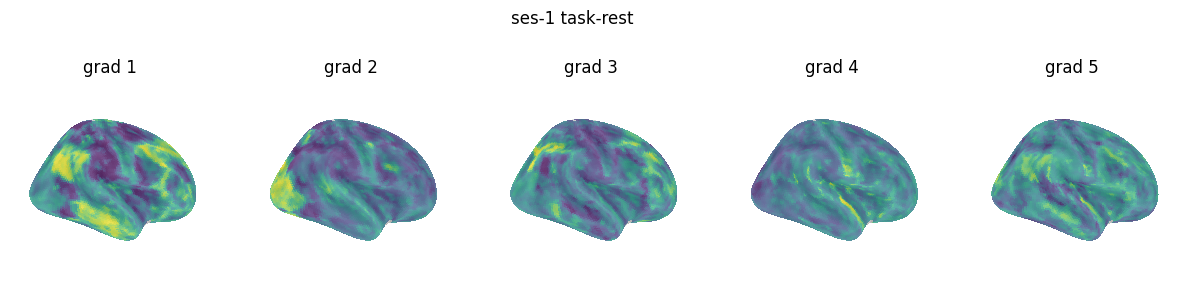

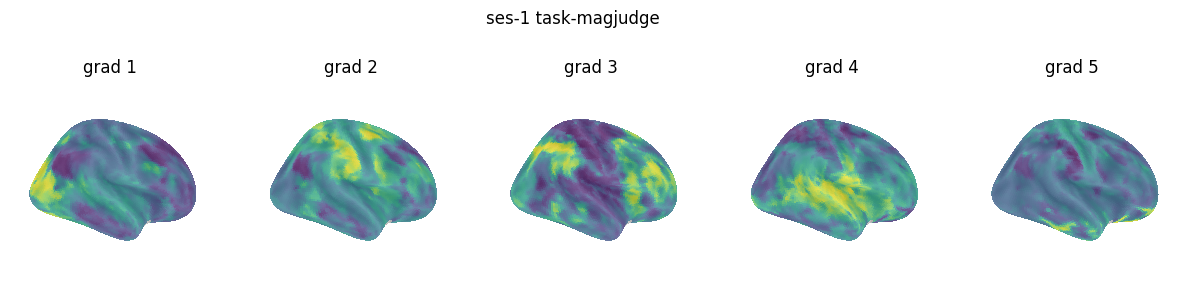

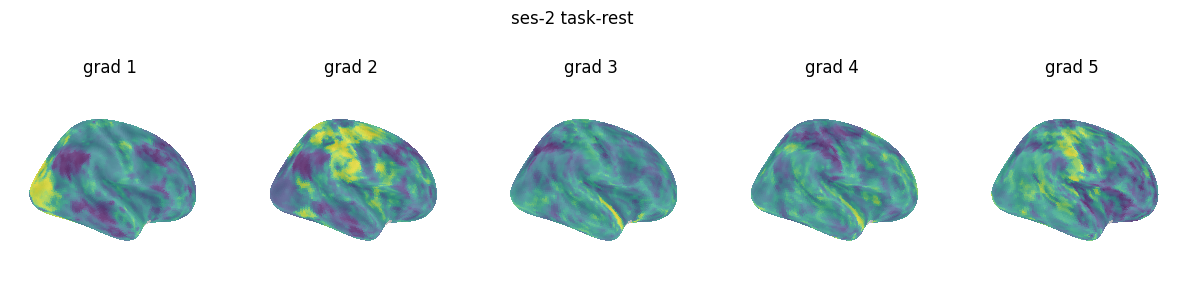

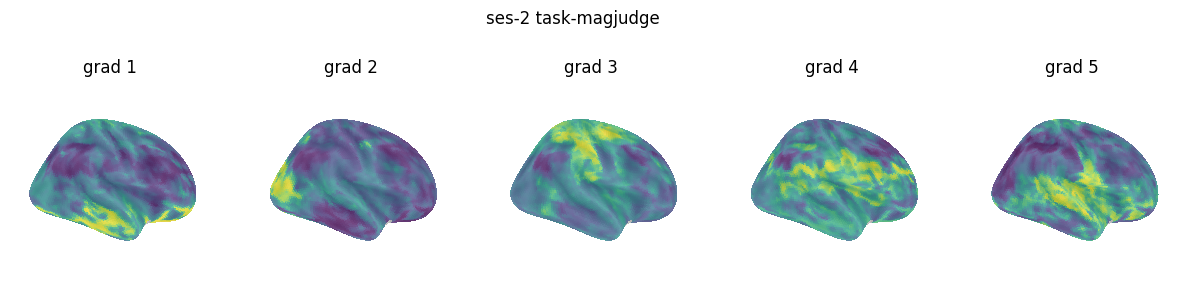

In [ ]:
ses_list = [1, 2]
tasks = ['rest', 'magjudge']

for i, ses in enumerate(ses_list):
    source_dir = op.join(bids_folder, 'derivatives', 'gradients', f'sub-{sub}', f'ses-{ses}')
    for j, task in enumerate(tasks):
        fn_grad = op.join(source_dir,f'sub-{sub}_ses-{ses}_task-{task}_gradients_space-fsaverag5_n10.npy')
        grad = np.load(fn_grad)
        
        figure, axes = plt.subplots(nrows=1, ncols=n_comp,figsize = (15,8), subplot_kw=dict(projection='3d'))
        for i in range(0,n_comp):
            n_grad= i+1
            gm = np.split(grad[i],2) # for i, hemi in enumerate(['L', 'R']): --> left first
            gm_r = gm[1]
            nplt.plot_surf(surf_mesh= fsaverage.infl_right, surf_map= gm_r, # infl_right # pial_right
                        view= side_view,cmap=cmap, colorbar=False,  # sub-{sub}, title=f'grad {i+1}',
                        bg_map=fsaverage.sulc_right, bg_on_data=True,darkness=0.7 ,axes=axes[i]) #
            axes[i].set(title=f'grad {n_grad}')
        figure.suptitle(f'ses-{ses} task-{task}',y = 0.71 )

Text(0.5, 0.98, 'Component Lambdas for Each Session and Task')

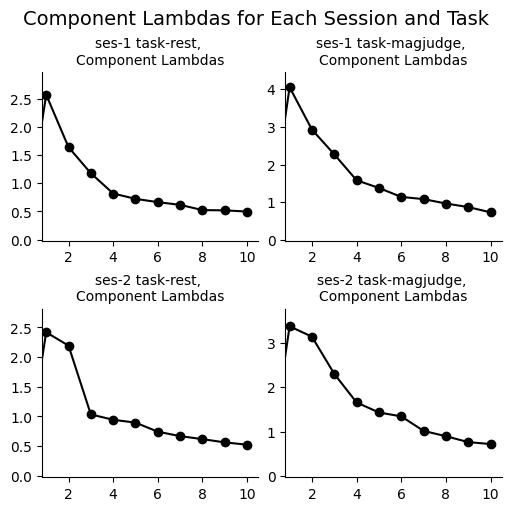

In [53]:
fig, axes = plt.subplots(len(ses_list), len(tasks), figsize=(5,5), facecolor='white', constrained_layout=True)

for i, ses in enumerate(ses_list):
    source_dir = op.join(bids_folder, 'derivatives', 'gradients', f'sub-{sub}', f'ses-{ses}')
    for j, task in enumerate(tasks):
        lambdas_path = op.join(source_dir, f'sub-{sub}_ses-{ses}_task-{task}_lambdas_space-fsaverag5_n10.npy')
        # Load lambdas
        lambdas = np.load(lambdas_path)
        vals = np.hstack((0, lambdas))
        ax = axes[i, j]
        ax.plot(vals, marker='o', mfc='k', mec='k', linestyle='-', color='k')
        ax.set(ylim=[-0.025, np.max(vals) + 0.4],xlim=[0.8,10.5] )
        ax.set_title(f'ses-{ses} task-{task}, \nComponent Lambdas', fontsize=10)
        sns.despine(ax=ax)

plt.suptitle('Component Lambdas for Each Session and Task', fontsize=14)
